In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from matplotlib import pyplot as plt
from tqdm import trange
from torch.distributions.normal import Normal
from torch.distributions.laplace import Laplace
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3)
        self.conv_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.relu = nn.ReLU()
        self.pooling = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(in_features=1600, out_features=10)

    def forward(self, x):
        x = self.relu(self.conv_0(x))
        x = self.pooling(x)
        x = self.relu(self.conv_1(x))
        x = self.pooling(x)
        x = x.view(-1, 1600)
        x = self.fc(x)
        return x

In [4]:
mdl = Model()

In [5]:
dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])

In [6]:
train_dataloader = DataLoader(train_set, batch_size = 128, shuffle=True)
test_dataloader = DataLoader(val_set, batch_size = 1000, shuffle=True)

In [7]:
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mdl.parameters(), lr = 1e-3)

In [8]:
n_epochs = 5
device = 'cuda'

In [9]:
writer = SummaryWriter()
mdl = mdl.to(device)
for i in trange(n_epochs):
    total_loss = 0
    for (x, y) in iter(train_dataloader):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        y_pred = mdl(x)
        loss = cross_entropy(y_pred, y)
        total_loss += loss
        loss.backward()
        optimizer.step()
    writer.add_scalar('Loss/train', total_loss / (len(train_dataloader)), i)
    if i % 15 == 0:
        mdl.eval()
        with torch.no_grad():
            total_loss = 0
            accuracy = 0
            for (x, y) in iter(test_dataloader):
                x = x.to(device)
                y = y.to(device)

                y_pred = mdl(x)
                loss_test = cross_entropy(y_pred, y)   
                total_loss += loss_test
                accuracy += (torch.argmax(y_pred, dim = -1) == y).sum() / len(y)
            writer.add_scalar('Loss/test', total_loss / len(test_dataloader), i)
            writer.add_scalar('Accuracy/test', accuracy / len(test_dataloader), i)
        mdl.train()

100%|█████████████████████████████████████████████| 5/5 [00:52<00:00, 10.42s/it]


In [10]:
mdl.eval()
with torch.no_grad():
    total_loss = 0
    accuracy = 0
    for (x, y) in iter(test_dataloader):
        x = x.to(device)
        y = y.to(device)

        y_pred = mdl(x)
        loss_test = cross_entropy(y_pred, y)   
        total_loss += loss_test
        accuracy += (torch.argmax(y_pred, dim = -1) == y).sum() / len(y)

In [11]:
accuracy / len(test_dataloader)

tensor(0.9880, device='cuda:0')

In [19]:
mdl

Model(
  (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1600, out_features=10, bias=True)
)

In [46]:
parameters = []
for param in mdl.parameters():
    parameters += param.view(-1, np.prod(param.shape)).detach().cpu().squeeze().tolist()

# or
#for name, param in model.named_parameters():

In [47]:
np.prod((3, 3, 3))

27

In [48]:
len(parameters)

53578

In [ ]:
np.histogram()

Text(0.5, 1.0, "Histogram with 'auto' bins")

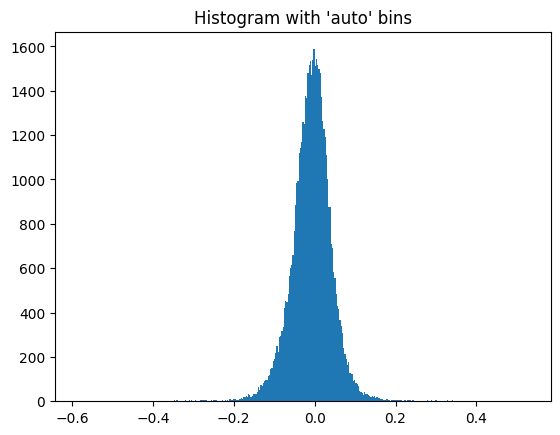

In [50]:
import matplotlib.pyplot as plt

_ = plt.hist(parameters, bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")

In [53]:
np.std(parameters)

0.05368772353526383

In [54]:
np.mean(parameters)

-0.007354980971496904

In [55]:
norm = Normal(-0.01, 0.05)

In [57]:
norm_sample = norm.sample((53000,))

In [59]:
lapl = Laplace(-0.01, 0.05)

In [60]:
lapl_sample = lapl.sample((53000, ))

Text(0.5, 1.0, "Histogram with 'auto' bins")

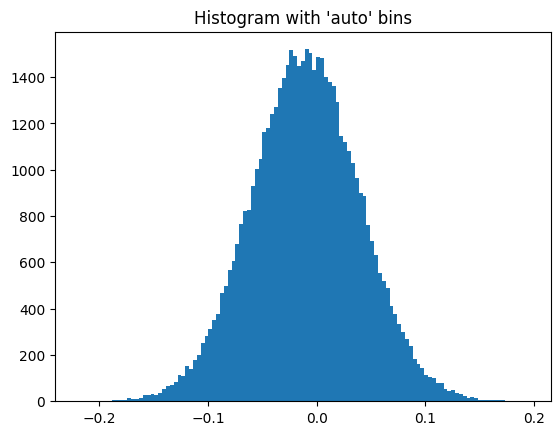

In [62]:
_ = plt.hist(norm_sample, bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")

Text(0.5, 1.0, "Histogram with 'auto' bins")

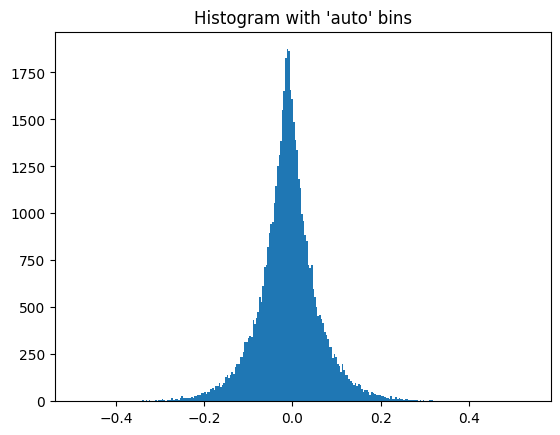

In [63]:
_ = plt.hist(lapl_sample, bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")